In [1]:
import subprocess
import nmrglue as ng # required for rading in data generated by SIMPSON
import numpy as np
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt

from floquet import *

In [6]:
def frequencies(
    hamiltonian, start, detect, frq_lower_limit, delta_frq, truncate=1e-6, npoints=4096
):
    """
    Calculation in frequency domain

    Parameters
    ----------
    hamiltonian : np.ndarray
        Defines the Hamiltonian under which the spin system evolves
    start : np.ndarray
        Start Operators
    detect : np.ndarray

    """

    # diagonalize
    eigenvalues, D = np.linalg.eig(hamiltonian)
    Dinv = D.conjugate().transpose()


    # change of basis for start and detect
    start_cs_eigenbasis = Dinv @ start @ D
    detect_cs_eigenbasis = Dinv @ detect @ D


    # transition probabilities
    spectrum = np.zeros(npoints, dtype="float64")
    intensities = detect_cs_eigenbasis * (start_cs_eigenbasis.transpose())
    # intensities = np.absolute(intensities)
    positions = np.argwhere(np.abs(intensities) > truncate)


    # transition frequencies
    for (i, j) in positions:
        frequency = eigenvalues[j] - eigenvalues[i]
        index = int((frequency.real - frq_lower_limit) / delta_frq)
        if 0 <= index < npoints:
            intensity = intensities[i, j]
            spectrum[index] += intensity.real


    return spectrum




In [7]:
def sidebands(sx, sy, sz, mas, fdim=13,):

    info = f"""\
    $\sigma_{{x}}$ = {sx :.0f} Hz
    $\sigma_{{y}}$ = {sy :.0f} Hz
    $\sigma_{{z}}$ = {sz :.0f} Hz
    $\\nu_{{r}}$ = {mas :.0f} Hz
    """

    # spin 1/2
    I = pauli()


    # sanitize input
    sx, sy, sz = sorted([float(i) for i in (sx, sy, sz)])
    mas = float(mas)
    iso = (sx + sy + sz) / 3
    span = sz - sx


    # reasonable frequency limits
    frq_llim, frq_hlim = iso - span - 10e3,  iso + span + 10e3
    delta_frq = (frq_hlim - frq_llim) / 4096


    # construct tensors
    CS_cart = tensor_setup(sigmax=sx, sigmay=sy, sigmaz=sz)
    CS_PAS = matrix_to_sphten(CS_cart)
    T = spherical_tensor_basis("spin", coord=[0, 0, 1])


    # term on the diagonal is the isotropic part
    terms = {}
    terms[0] = CS_PAS[0, 0] * T[0, 0]


    # start and detect operators
    detect_op = F(n=0, fdim=fdim, term=I["p"])
    start_op = F(n=(0, 0), fdim=fdim, term=I["x"])
    

    # initialize for accumulation of data
    ft = np.zeros(4096)


    # powder averaging
    for theta in np.linspace(0, pi, 32):
        for phi in np.linspace(0, 2 * pi, 32):

            CS = rotate(CS_PAS, phi, theta, 0,)
            terms[1] = CS[2, 1] * T[2, 0] / sqrt(3)
            terms[2] = CS[2, 2] * T[2, 0] / sqrt(6)
            terms[-1] = terms[1].transpose().conjugate() 
            terms[-2] = terms[2].transpose().conjugate()

            fmat = N(fdim=fdim, term=mas)
            for k, v in terms.items():
                fmat += F(n=k, fdim=fdim, term=v)

            # actual calculation
            out = frequencies(
                fmat, start_op, detect_op, frq_lower_limit=-frq_hlim, delta_frq=delta_frq, npoints=4096
            )
            
            # accumulate and weigh depending on the crystallite
            out *= sin(theta)
            ft += out

    # process
    xscale = np.linspace(frq_llim, frq_hlim, 4096) 
    fid = np.fft.ifft(ft)
    fid *= np.exp(-7.5e-3 * np.arange(fid.shape[-1]))
    ft = np.fft.fft(fid)[::-1]
    ft = ft - np.min(ft)

    return xscale, ft 

In [8]:
def simpson(sx, sy, sz, mas):
    
    sx, sy, sz, mas = [float(i) for i in [sx, sy, sz, mas]]
    
    iso = (sx + sy + sz) / 3
    aniso = sz - iso
    red_aniso = sz - 1/2 * (sx + sy)
    
    if aniso < 1e-6:
        aniso = 0
        eta = 0
        
    else:
        eta = (sy - sx) / aniso
        
    if mas == 0:
        crystal_file = "zcw28656"
        method = "direct"
        gamma_angles = 1
        sw = 50e3
        npts = 8192
        lb = 100
    
    elif mas > 0:
        crystal_file = "rep320"
        method = "gcompute"
        gamma_angles = 32
        sw = mas * gamma_angles
        npts = 65536
        lb = 75
              
    simprg = f"""\n

spinsys {{

    # channels and nuclei
    channels 13C 
    nuclei 13C

    # shift i   iso   aniso  eta   alpha beta  gamma
    shift   1   {iso}  {aniso} {eta}     0     0     0
   
}}

par {{

    proton_frequency    700e6
    spin_rate           {mas}
    crystal_file        {crystal_file}
    method              {method}
    gamma_angles        {gamma_angles}
    sw                  {sw}
    start_operator      I1x
    detect_operator     I1p
    num_cores           4
    verbose             1101
    np                  {npts}

}}

proc pulseq {{}} {{
    global par

    # new parameters
    set dw [expr 1e6/$par(sw)]

    # acq_block
    reset
    acq_block {{
        delay $dw
    }}


}}

proc main {{}} {{
    global par

    set f [fsimpson]
    fsave $f $par(name).fid
#    funload $f
    
    # proc
    fzerofill $f 65536
    faddlb    $f {lb} 0
    fft       $f 
    fsave $f $par(name).ft
    funload $f
    
}}
"""
    
    subprocess.run("rm test.sim".split())
    
    with open("test.sim", "w") as f:
        f.write(simprg)
        
    subprocess.run("rm -r test.fid test.ft".split())
    subprocess.run(["simpson", "test.sim"])
    
    xscale = np.linspace(-sw/2+iso, sw/2+iso, 65536)
    
    if method ==  "frequency":
        dic, data = ng.simpson.read("test.fid")
    else:
        dic, data = ng.simpson.read("test.ft")
        
        
    return xscale, data[0]/np.max(data[0].real)

In [11]:
def compare(sx, sy, sz, mas):
    
    cdata = {}
    cdata["floquet"] = sidebands(sx, sy, sz, mas)
    print("Done Floquet")
    cdata["static"] = simpson(sx, sy, sz, 0)
    print("Done Static")
    cdata["simpson"] = simpson(sx, sy, sz, mas)
    
    cdata["info"] = """
                  $\delta_{{xx}}$ = {:.0f} kHz
                  $\delta_{{yy}}$ = {:.0f} kHz 
                  $\delta_{{zz}}$ = {:.0f} kHz
                  $\omega_r$ = 1 kHz""".format(sx/1e3, sy/1e3, sz/1e3)
    
    
    return cdata 

In [12]:
data = {}

data[0.0] = compare(-2e3, -2e3, 4e3, 1e3)
data[1.0] = compare(-4e3, 0e3, 4e3, 1e3)
data[0.25] = compare(-3e3, -2e3, 4e3, 1e3)

Done Floquet
Done Static
Done Floquet
Done Static
Done Floquet
Done Static


In [13]:
def norm(d):
    return d / np.max(d)

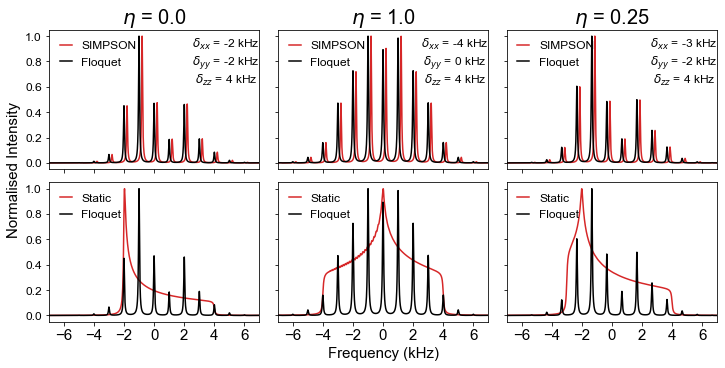

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True)

for axis in ax.flat:
    axis.set_facecolor("white")
    for i in ["top", "bottom", "left", "right" ]:
        axis.spines[i].set_edgecolor("k")


ccol = 0
for k, v in data.items():
    if k == 0.25:
        shift = 1.0/3
    else:
        shift = 0.
    ax[0, ccol].plot(v["simpson"][0]/1e3+0.2+shift, norm(v["simpson"][1].real), color="tab:red", label="SIMPSON")
    ax[1, ccol].plot(v["static"][0]/1e3+shift, norm(v["static"][1].real), color="tab:red", label="Static")

    for i in range(2):
        ax[i, ccol].plot(v["floquet"][0]/1e3, norm(v["floquet"][1].real), color="black", label="Floquet")
        if i == 0:
            ax[i, ccol].text(2.8, 0.8, v["info"].split(r"$\omega")[0], 
                  ha="center", va="center", fontsize=12) 
        
    ccol += 1
    
for i, (k, v) in enumerate(data.items()):
    ax[0, i].set_title(f"$\eta$ = {k}", fontsize=20)
    
for i, axis in enumerate(ax.flat):
    axis.set_xlim(-7, 7)
    axis.legend(loc=2, frameon=False, handlelength=1, fontsize=12)
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)


ax[1, 1].set_xlabel("Frequency (kHz)", fontsize=15)
ax[0, 0].set_ylabel("Normalised Intensity", fontsize=15, position=(-7, 0))

plt.show()